In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list

In [ ]:
# !kaggle competitions download -c cassava-leaf-disease-classification

In [ ]:
# !cp /content/cassava-leaf-disease-classification.zip /content/drive/MyDrive/Personal/FuseMachine

In [ ]:
# !unzip /content/drive/MyDrive/Personal/FuseMachine/cassava-leaf-disease-classification.zip -d /content/drive/MyDrive/Personal/FuseMachine/

# Train with naive CNN Model

In [ ]:
from glob import glob
import cv2

import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics

from skimage import io
from scipy.ndimage.interpolation import zoom


import os
from datetime import datetime
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss

import warnings
import joblib


# import pydicom
# import timm #
# from efficientnet_pytorch import EfficientNet


In [ ]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Personal/FuseMachine/train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [ ]:
train = train.loc[:2000, :]

In [ ]:
train.label.value_counts()

3    1235
4     242
2     220
1     215
0      89
Name: label, dtype: int64

In [ ]:
len(train)

2001

## Helper Functions

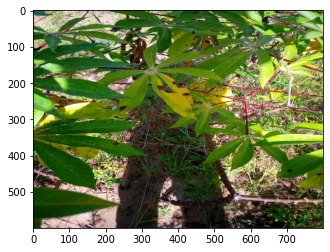

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('/content/drive/MyDrive/Personal/FuseMachine/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

In [ ]:
img.shape

(600, 800, 3)

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, output_label=True, one_hot_label=False):

        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
        self.one_hot_label = one_hot_label

        if output_label == True:
            self.labels = self.df['label'].values

            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max() + 1)[self.labels]

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):

        # get labels
        if self.output_label:
            target = self.labels[index]

        img = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']


        if self.output_label == True:
            return torch.from_numpy(img.copy()), target
            #return img, target
        else:
            return img




In [ ]:
def makeTheNet():
    class CassavaImgClassifier(nn.Module):
        def __init__(self):
            super().__init__()

            ### ------------------- feature map layers ------------------- ###
            # first convolution layer
            self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(64)
            #size (Height): np.floor( (600 + 2*1 -3)/1) + 1 = 600/2 = 300 (/2 b/c maxpool)
            #size (Width): np.floor( (800 + 2*1 -3)/1) + 1 = 800/2 = 400 (/2 b/c maxpool)

            # second convolution layer
            self.conv2 = nn.Conv2d(64, 256, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(256)
            #size (Height): np.floor( (300 + 2*1 -3)/1) + 1 = 300/2 = 150 (/2 b/c maxpool)
            #size (Width): np.floor( (400 + 2*1 -3)/1) + 1 = 400/2 = 200 (/2 b/c maxpool)

            # third convolution layer
            self.conv3 = nn.Conv2d(256, 512, 3, padding=1)
            self.bnorm3 = nn.BatchNorm2d(512)
            #size (Height): np.floor( (150 + 2*1 -3)/1) + 1 = 150/2 = 75 (/2 b/c maxpool)
            #size (Width): np.floor( (200 + 2*1 -3)/1) + 1 = 200/2 = 100 (/2 b/c maxpool)

            # compute the number of units in FC layer (number of output of conv3)
            expectHeightSize = np.floor((75 + 2 * 0 - 1)/1) + 1
            expectWidthSize = np.floor((100 + 2 * 0 - 1)/1) + 1
            expectSize = int(512 * expectHeightSize * expectWidthSize)

            print(expectSize)

            ### fully-connected layer
            self.fc1 = nn.Linear(expectSize, 250)
            self.fc2 = nn.Linear(250, 50)

            ### output layer
            self.out = nn.Linear(50, 4)


        def forward(self, x):
            print(x.shape)
            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            x = F.dropout(x, p=.25, training=self.training)

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            x = F.dropout(x, p=.25, training=self.training)

            # third block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bnorm3(x))
            x = F.dropout(x, p=.25, training=self.training)

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = self.out(x)

            return x

    net = CassavaImgClassifier()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer






In [ ]:
# # test the model with one batch
# net, lossfun, optimizer = makeTheNet()

In [ ]:
# net

In [ ]:
# train_loader, _ = prepare_dataloader(train)

In [ ]:
# X, y = iter(train_loader).next()
# X.shape

In [ ]:
# # for getting summary info on models
# from torchsummary import summary

In [ ]:
# summary(net,(3,600,800))

In [ ]:
import gc
gc.collect()

2632

In [ ]:
# !pip install catalyst

In [ ]:
# from catalyst.data.sampler import BalanceClassSampler

In [ ]:
# def prepare_dataloader(df, trn_idx, val_idx, data_root='/content/drive/MyDrive/Personal/FuseMachine/train_images/'):
#     train_ = df.loc[trn_idx, :].reset_index(drop=True)
#     valid_ = df.loc[val_idx, :].reset_index(drop=True)

#     train_ds = CassavaDataset(train_, data_root, transforms=False, output_label=True, one_hot_label=False)
#     valid_ds = CassavaDataset(valid_, data_root, transforms=False, output_label=True)

#     train_loader = DataLoader(
#         train_ds,
#         batch_size=CFG['train_bs'],
#         pin_memory=False,
#         drop_last=False,
#         shuffle=True,
#         num_workers=CFG['num_workers']
#     )

#     valid_loader = DataLoader(
#         valid_ds,
#         batch_size=CFG['valid_ds'],
#         num_workers=CFG['num_workers'],
#         shuffle=False,
#         pin_memory=False,
#     )

#     return train_loader, valid_loader



In [ ]:
def prepare_dataloader(df, data_root='/content/drive/MyDrive/Personal/FuseMachine/train_images/'):
    n = len(df)
    trn_idx = int(n*.8)
    train_ = df.loc[:trn_idx, :].reset_index(drop=True)
    valid_ = df.loc[trn_idx:, :].reset_index(drop=True)

    train_ds = CassavaDataset(train_, data_root, transforms=False, output_label=True, one_hot_label=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=False, output_label=True)

    train_loader = DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,
        num_workers=CFG['num_workers']
    )

    valid_loader = DataLoader(
        valid_ds,
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )

    return train_loader, valid_loader



In [ ]:
# a function that trains the model
import gc
def function2trainTheModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # initalize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    validAcc = []

    train_loader, valid_loader = prepare_dataloader(train)


    # loop over epochs
    for epochi in range(numepochs):
        gc.collect()
        print(f'{epochi+1} is running...')

        # loop over training batches
        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            # print(X.size())
            X = torch.permute(X, (0,3, 1, 2))
            yHat = net(X.float())
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        # end of the loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # valid accuracy
        net.eval()
        batchValidAcc = []
        for X, y in valid_loader:
            X = torch.permute(X, (0,3, 1, 2))
            with torch.no_grad():
                yHat = net(X.float())

            # compare the following really long line of code to the training accuracy lines
            batchValidAcc.append(100*torch.mean((torch.argmax(yHat, axis=1) == y).float()))
        validAcc.append(np.mean(batchValidAcc))

    # end epochs

    # function output
    return trainAcc, validAcc, losses, net



In [ ]:
seed_everything(2022)

In [ ]:
trainAcc, validAcc, losses, net = function2trainTheModel()

3840000
1 is running...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 3, 600, 800])


In [ ]:
gc.collect()

220

# Trained with Pretrain model

In [ ]:
import gc
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import os

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch

from imblearn.over_sampling import RandomOverSampler


from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [ ]:
#train = pd.read_csv('train.csv').head(200)
data = pd.read_csv('/content/drive/MyDrive/Personal/FuseMachine/train.csv').head(8000)

data

image_id  label
0     1000015157.jpg      0
1     1000201771.jpg      3
2      100042118.jpg      1
3     1000723321.jpg      1
4     1000812911.jpg      3
...              ...    ...
7995   242121354.jpg      4
7996  2421223189.jpg      3
7997  2421310998.jpg      3
7998  2421492761.jpg      3
7999  2421566220.jpg      2

[8000 rows x 2 columns]

In [ ]:
data['label'].value_counts()

3    4925
4     985
2     912
1     804
0     374
Name: label, dtype: int64

In [ ]:
data.dtypes

image_id    object
label        int64
dtype: object

In [ ]:
label_classes = {0:"Cassava Bacterial Blight (CBB)",
                 1:"Cassava Brown Streak Disease (CBSD)",
                 2:"Cassava Green Mottle (CGM)",
                 3:"Cassava Mosaic Disease (CMD)",
                 4:"Healthy"
                 }

In [ ]:
class_converter = {'Cassava Bacterial Blight (CBB)': 0,
                   'Cassava Mosaic Disease (CMD)': 3,
                   'Cassava Brown Streak Disease (CBSD)': 1,
                   'Cassava Green Mottle (CGM)': 2,
                   'Healthy': 4}

In [ ]:
data['class'] = data['label'].replace([0, 1, 2, 3, 4], [label_classes[0],label_classes[1],label_classes[2],label_classes[3],label_classes[4]])

In [ ]:
data

image_id  label                                class
0     1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1     1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2      100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3     1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4     1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...              ...    ...                                  ...
7995   242121354.jpg      4                              Healthy
7996  2421223189.jpg      3         Cassava Mosaic Disease (CMD)
7997  2421310998.jpg      3         Cassava Mosaic Disease (CMD)
7998  2421492761.jpg      3         Cassava Mosaic Disease (CMD)
7999  2421566220.jpg      2           Cassava Green Mottle (CGM)

[8000 rows x 3 columns]

In [ ]:
TEST_DATA_DIR = '/content/drive/MyDrive/Personal/FuseMachine/test_images'
TRAIN_DATA_DIR = '/content/drive/MyDrive/Personal/FuseMachine/train_images/'

In [ ]:
os.listdir(TEST_DATA_DIR)

['2216849948.jpg']

In [ ]:
files = os.listdir(TRAIN_DATA_DIR)[:100]
files[:5]

['802266352.jpg',
 '807190211.jpg',
 '811520495.jpg',
 '795383461.jpg',
 '816404060.jpg']

In [ ]:
from torch.utils.data import Dataset, DataLoader, IterableDataset

In [ ]:
class CassavaLeafDiseaseDataset(IterableDataset):
    def __init__(self, root, files, labels, classes, transform):
        super(CassavaLeafDiseaseDataset).__init__()
        self.root = root
        self.files = files
        self.labels = labels
        self.classes = classes
        self.transform = transform
        self.start = 0
        self.end = len(files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(Image.open(fpath).convert('RGB'))
        class_label_int = self.labels[i]
        return img, class_label_int

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)
        return map(self.__getitem__, range(iter_start, iter_end))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
df = {}
train_df, testval_df = train_test_split(
    data, stratify=data.label, train_size=0.8, random_state=2022
)

valid_df, test_df = train_test_split(
    testval_df, stratify=testval_df.label, train_size=0.5, random_state=2022
)

In [ ]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df, test_df, valid_df

(            image_id  label
 0     2240458370.jpg      3
 1     1947066099.jpg      0
 2     2381876074.jpg      3
 3     1672763395.jpg      1
 4     1077032520.jpg      1
 ...              ...    ...
 6395  1617366913.jpg      2
 6396   122863277.jpg      3
 6397  1254020596.jpg      3
 6398  1201703302.jpg      1
 6399  1708272304.jpg      3
 
 [6400 rows x 2 columns],            image_id  label
 0    1343301467.jpg      2
 1    1040828572.jpg      3
 2    1634815405.jpg      1
 3    1595141360.jpg      0
 4    2030421746.jpg      3
 ..              ...    ...
 795   112619806.jpg      3
 796  1536737469.jpg      0
 797  1490838967.jpg      4
 798  1668819589.jpg      3
 799  2136656300.jpg      4
 
 [800 rows x 2 columns],            image_id  label
 0    2421492761.jpg      3
 1    1499416552.jpg      3
 2    1542540755.jpg      2
 3    1858778383.jpg      2
 4    1648724139.jpg      4
 ..              ...    ...
 795  1983523977.jpg      4
 796  1830778747.jpg      3
 797  13123

In [ ]:
datasets = {}
datasets['train'] = CassavaLeafDiseaseDataset(TRAIN_DATA_DIR, train_df['image_id'].to_numpy(),
                                              train_df['label'].to_numpy(), label_classes, T.ToTensor())

datasets['valid'] = CassavaLeafDiseaseDataset(TRAIN_DATA_DIR, valid_df['image_id'].to_numpy(),
                                             valid_df['label'].to_numpy(), label_classes, T.ToTensor())

datasets['test'] = CassavaLeafDiseaseDataset(TRAIN_DATA_DIR, test_df['image_id'].to_numpy(),
                                             test_df['label'].to_numpy(), label_classes, T.ToTensor())

In [ ]:
batch_size = 16
dataloaders = {}
dataloaders['train'] = DataLoader(datasets['train'], batch_size, num_workers=2, pin_memory=False, shuffle=False, drop_last=True)
dataloaders['valid'] = DataLoader(datasets['valid'], batch_size, num_workers=2, pin_memory=False, drop_last=True)
dataloaders['test'] = DataLoader(datasets['test'], batch_size, num_workers=2, pin_memory=False, drop_last=True)

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 14.3 MB/s 
     |████████████████████████████████| 182 kB 67.1 MB/s 


In [ ]:
from timm.data import create_transform


In [ ]:
def show_image(data):
    img, label = data
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print('Label: ' + label_classes[label])

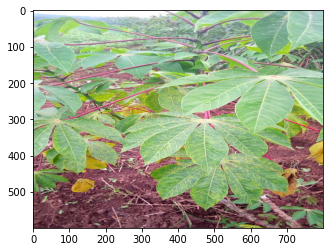

Label: Cassava Brown Streak Disease (CBSD)


In [ ]:
show_image(datasets['train'][3])

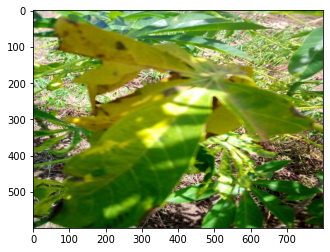

Label: Cassava Bacterial Blight (CBB)


In [ ]:
show_image(datasets['test'][3])

In [ ]:
datasets['train'].transform = create_transform(384, is_training=True)


In [ ]:
datasets['valid'].transform = T.Compose([T.Resize(size=400),
                                        T.CenterCrop(size=(384, 384)),
                                        T.ToTensor()])

In [ ]:
datasets['test'].transform = T.Compose([T.Resize(size=400),
                                        T.CenterCrop(size=(384, 384)),
                                        T.ToTensor()])

In [ ]:
create_transform(600, is_training=False)

Compose(
    Resize(size=685, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(600, 600))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

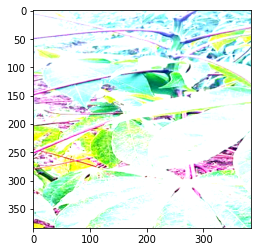

Label: Cassava Brown Streak Disease (CBSD)


In [ ]:
show_image(datasets['train'][3])

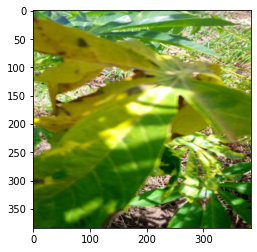

Label: Cassava Bacterial Blight (CBB)


In [ ]:
show_image(datasets['test'][3])

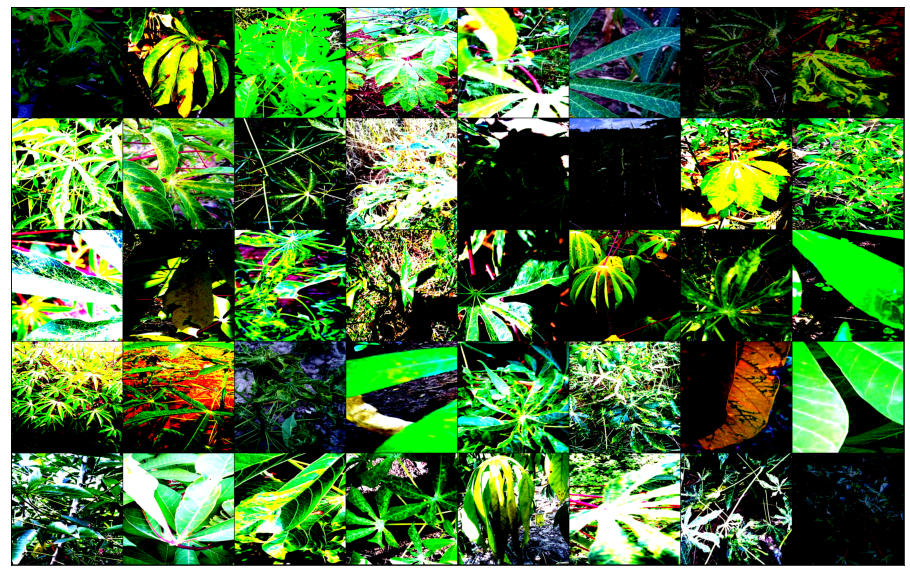

In [ ]:
from torchvision.utils import make_grid
def show_dataset(ds):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    images = []
    for i in range(40):
        image, label = ds[i]
        images.append(image)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

show_dataset(datasets['train'])

In [ ]:
gc.collect()

11636

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Convnext_tiny model

In [ ]:
model_ft = models.convnext_tiny(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = False

n_inputs = 768
n_outputs = 5


sequential_layers = nn.Sequential(
    nn.Linear(n_inputs, 384),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(384, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, n_outputs),
    nn.LogSoftmax(dim=1)
)
model_ft.classifier[2] = sequential_layers

#model_ft.avgpool = nn.AdaptiveMaxPool2d(output_size=1)

for (param1, param2, param3) in zip(model_ft.classifier.parameters(), model_ft.features[7].parameters(), model_ft.avgpool.parameters()):
    param1.requires_grad, param2.requires_grad, param3.requires_grad = True

In [ ]:
model_ft = model_ft.to(device)

In [ ]:
criterion = nn.NLLLoss()

## ResNet50

In [ ]:
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
model_rs50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# model_rs50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
class CassavaNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = model_rs50
        n_features = backbone.fc.in_features
        self.backbone = nn.Sequential(*backbone.children())[:-2]
        self.classifier = nn.Linear(n_features, 5)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward_features(self, x):
        x = self.backbone(x)
        return x

    def forward(self, x):
        feats = self.forward_features(x)
        x = self.pool(feats).view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
net =  CassavaNet()
net.to(device)

CassavaNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [ ]:
test_in = torch.ones((16,3,384,384)).to(torch.device('cuda'),non_blocking=True)
test_out = net(test_in)
print(test_out.shape)

torch.Size([16, 5])


In [ ]:
def evaluate(model, dataloader):
    outputs = []
    with torch.no_grad():
        model.eval()
        for batch in dataloader:
            images, labels = batch
            images = images.to(torch.device('cuda'),non_blocking=True)
            labels = labels.to(torch.device('cuda'),non_blocking=True)
            out = model(images)
            loss = F.cross_entropy(out, labels)

            _, preds = torch.max(out, dim=1)
            acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
            outputs.append({'test_loss': loss.detach(), 'test_acc': acc})

        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        result = {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
        torch.cuda.empty_cache()

    return result

In [ ]:
history = [evaluate(net, dataloaders['test'])]
history

[{'test_loss': 1.8045992851257324, 'test_acc': 0.10875000059604645}]

In [ ]:
# # from ignite.engine import create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Loss, Accuracy
# from ignite.contrib.handlers import FastaiLRFinder, ProgressBar

In [ ]:
optimizer = torch.optim.Adam([{'params': net.backbone[7].parameters()},
                              {'params': net.pool.parameters()},
                              {'params': net.classifier.parameters(),
                               'lr': 1e-7 }],
                              lr=0.001 / 10, weight_decay=0.001)

In [ ]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.52E-03


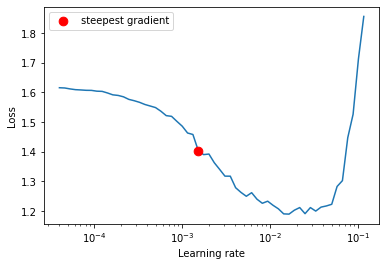

In [ ]:
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'],start_lr = 1e-5, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
gc.collect()

49

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_fine_tuning(epochs, lr, model, train_loader, valid_loader, weight_decay,
                      device, accum_iter, print_every, optimizer=torch.optim.Adam):

    optimizer = optimizer([{'params': model.backbone[7].parameters()},
                           {'params': model.pool.parameters()},
                           {'params': model.classifier.parameters(),
                            'lr': lr }],
                          lr=lr / 10, weight_decay=weight_decay)
    criterion = nn.NLLLoss()
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    total_hist = [[],[],[],[]]

    # batch accumulation parameter
    accum_iter = accum_iter

    steps = 0
    running_loss = 0
    running_accuracy = 0
    print_every = print_every

    for epoch in range(epochs):

        model.train()

        for batch_idx, (images, labels) in enumerate(train_loader):
            steps += 1

            images,labels = images.to(device),labels.to(device)

            with torch.set_grad_enabled(True):

                y_hat = model(images)
                loss = criterion(y_hat, labels)

                running_loss += loss.item()

                ps = torch.exp(y_hat)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


                loss = loss / accum_iter

                loss.backward()

                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                    optimizer.step()
                    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1)
                    optimizer.zero_grad()






                del images,labels,y_hat
                torch.cuda.empty_cache()

                if steps % print_every == 0:
                    valid_loss = 0
                    accuracy = 0
                    with torch.no_grad():
                        model.eval()
                        for images2, labels2 in tqdm(valid_loader):

                            images2, labels2 = images2.to(device),labels2.to(device)

                            y_hat2 = model(images2)
                            batch_loss = criterion(y_hat2, labels2)

                            valid_loss += batch_loss.item()

                            # Calculate accuracy
                            ps2 = torch.exp(y_hat2)
                            top_p2, top_class2 = ps2.topk(1, dim=1)
                            equals2 = top_class2 == labels2.view(*top_class2.shape)
                            accuracy += torch.mean(equals2.type(torch.FloatTensor)).item()

                            del images2,labels2,y_hat2
                            torch.cuda.empty_cache()

                    train_loss = running_loss/print_every
                    train_accuracy = running_accuracy/print_every
                    valid_loss = valid_loss/len(valid_loader)
                    valid_accuracy = accuracy/len(valid_loader)
                    total_hist[0].append(train_loss)
                    total_hist[1].append(train_accuracy)
                    total_hist[2].append(valid_loss)
                    total_hist[3].append(valid_accuracy)

                    print(f"Epoch {epoch+1}/{epochs}.. "
                          f"Train loss: {train_loss:.3f}.. "
                          f"Valid loss: {valid_loss:.3f}.. "
                          f"Valid accuracy: {valid_accuracy:.3f}")
                    running_loss = 0
                    model.train()

                    sched.step(valid_loss)

        torch.cuda.empty_cache()
        gc.collect()


    train_total_loss = np.array(total_hist[0])
    train_total_acc = np.array(total_hist[1])

    val_total_loss = np.array(total_hist[2])
    val_total_acc = np.array(total_hist[3])


    total = {'train_loss': train_total_loss, 'train_acc': train_total_acc,
               'val_loss': val_total_loss, 'val_acc': val_total_acc}
    print('\n _______________\n Total: {} \n _______________'.format(total))

    return pd.DataFrame({'Train Loss':total_hist[0], 'Train Accuracy':total_hist[1],
                         'Val Loss':total_hist[2], 'Val Accuracy':total_hist[3]})

In [ ]:
len(dataloaders['train'])/10

40.0

In [ ]:
x, y = next(iter(dataloaders['valid']))
x.shape, y.shape

(torch.Size([16, 3, 384, 384]), torch.Size([16]))

In [ ]:
epochs = 20
lr = 0.002
grad_clip = 1
optimizer = torch.optim.AdamW
weight_decay = 0.001
#steps_per_epochs=64
accum_iter = 10
print_every = 10
#momentum = 0.9

In [ ]:
%%time
history2 = train_fine_tuning(epochs, lr, net, dataloaders['train'], dataloaders['valid'],
                             weight_decay, device, accum_iter, print_every, optimizer)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -0.283.. Valid loss: -2.205.. Valid accuracy: 0.666


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -2.361.. Valid loss: -3.159.. Valid accuracy: 0.339


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -4.419.. Valid loss: -4.874.. Valid accuracy: 0.207


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -6.571.. Valid loss: -7.426.. Valid accuracy: 0.279


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -8.706.. Valid loss: -9.944.. Valid accuracy: 0.278


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -10.935.. Valid loss: -11.933.. Valid accuracy: 0.230


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -13.313.. Valid loss: -14.859.. Valid accuracy: 0.201


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -15.803.. Valid loss: -17.598.. Valid accuracy: 0.261


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -17.977.. Valid loss: -20.246.. Valid accuracy: 0.217


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -20.487.. Valid loss: -22.522.. Valid accuracy: 0.177


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -22.820.. Valid loss: -25.556.. Valid accuracy: 0.159


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -25.657.. Valid loss: -26.923.. Valid accuracy: 0.188


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -28.402.. Valid loss: -28.435.. Valid accuracy: 0.221


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -30.766.. Valid loss: -31.156.. Valid accuracy: 0.209


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -33.890.. Valid loss: -33.107.. Valid accuracy: 0.220


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -36.604.. Valid loss: -35.251.. Valid accuracy: 0.233


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -39.714.. Valid loss: -37.643.. Valid accuracy: 0.223


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -42.162.. Valid loss: -41.009.. Valid accuracy: 0.200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -44.973.. Valid loss: -43.189.. Valid accuracy: 0.226


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -47.610.. Valid loss: -47.146.. Valid accuracy: 0.201


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -51.928.. Valid loss: -49.831.. Valid accuracy: 0.223


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -54.472.. Valid loss: -52.876.. Valid accuracy: 0.211


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -56.935.. Valid loss: -58.765.. Valid accuracy: 0.170


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -59.944.. Valid loss: -60.527.. Valid accuracy: 0.225


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -63.439.. Valid loss: -64.102.. Valid accuracy: 0.245


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -67.331.. Valid loss: -66.913.. Valid accuracy: 0.278


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -69.983.. Valid loss: -71.328.. Valid accuracy: 0.229


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -72.322.. Valid loss: -76.618.. Valid accuracy: 0.198


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -76.979.. Valid loss: -78.110.. Valid accuracy: 0.206


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -78.606.. Valid loss: -80.422.. Valid accuracy: 0.244


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -82.560.. Valid loss: -84.124.. Valid accuracy: 0.228


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -87.351.. Valid loss: -89.171.. Valid accuracy: 0.210


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -89.941.. Valid loss: -92.585.. Valid accuracy: 0.220


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -92.849.. Valid loss: -95.379.. Valid accuracy: 0.230


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -98.165.. Valid loss: -98.613.. Valid accuracy: 0.174


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -98.866.. Valid loss: -105.657.. Valid accuracy: 0.125


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -104.597.. Valid loss: -108.353.. Valid accuracy: 0.128


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -106.296.. Valid loss: -113.240.. Valid accuracy: 0.081


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -110.858.. Valid loss: -112.022.. Valid accuracy: 0.080


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20.. Train loss: -115.875.. Valid loss: -118.932.. Valid accuracy: 0.061


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -117.447.. Valid loss: -116.436.. Valid accuracy: 0.065


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -122.256.. Valid loss: -123.810.. Valid accuracy: 0.051


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -124.019.. Valid loss: -127.408.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -128.055.. Valid loss: -132.247.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -131.966.. Valid loss: -138.673.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -135.303.. Valid loss: -144.436.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -139.244.. Valid loss: -146.635.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -143.846.. Valid loss: -142.012.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -145.900.. Valid loss: -147.771.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -149.253.. Valid loss: -157.357.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -153.940.. Valid loss: -169.237.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -158.013.. Valid loss: -168.550.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -162.157.. Valid loss: -162.937.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -165.349.. Valid loss: -167.485.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -170.449.. Valid loss: -176.240.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -173.585.. Valid loss: -179.951.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -178.717.. Valid loss: -177.740.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -181.602.. Valid loss: -180.693.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -185.704.. Valid loss: -179.499.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -189.672.. Valid loss: -191.792.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -194.936.. Valid loss: -195.089.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -197.336.. Valid loss: -199.222.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -200.636.. Valid loss: -208.105.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -205.321.. Valid loss: -202.656.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -208.819.. Valid loss: -205.617.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -216.208.. Valid loss: -209.539.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -217.998.. Valid loss: -217.185.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -220.563.. Valid loss: -225.897.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -228.913.. Valid loss: -223.130.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -228.917.. Valid loss: -223.640.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -235.050.. Valid loss: -228.975.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -239.886.. Valid loss: -243.426.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -241.946.. Valid loss: -240.560.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -243.442.. Valid loss: -240.905.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -252.145.. Valid loss: -251.324.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -252.147.. Valid loss: -263.163.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -262.628.. Valid loss: -263.893.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -261.473.. Valid loss: -273.027.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -269.618.. Valid loss: -264.420.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20.. Train loss: -275.777.. Valid loss: -271.077.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -273.517.. Valid loss: -270.800.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -282.417.. Valid loss: -286.061.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -282.727.. Valid loss: -286.224.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -289.384.. Valid loss: -284.964.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -293.571.. Valid loss: -294.514.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -297.993.. Valid loss: -301.108.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -302.101.. Valid loss: -312.287.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -307.520.. Valid loss: -307.306.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -309.584.. Valid loss: -311.866.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -316.343.. Valid loss: -314.116.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -320.110.. Valid loss: -329.855.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -326.445.. Valid loss: -329.393.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -329.579.. Valid loss: -322.396.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -332.655.. Valid loss: -323.948.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -338.959.. Valid loss: -331.731.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -341.509.. Valid loss: -344.205.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -349.166.. Valid loss: -350.343.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -353.782.. Valid loss: -353.614.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -355.676.. Valid loss: -347.602.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -362.727.. Valid loss: -352.430.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -368.331.. Valid loss: -355.477.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -369.430.. Valid loss: -367.379.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -376.480.. Valid loss: -380.060.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -378.329.. Valid loss: -377.907.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -383.488.. Valid loss: -384.894.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -390.097.. Valid loss: -387.528.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -394.839.. Valid loss: -390.629.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -394.069.. Valid loss: -410.837.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -404.481.. Valid loss: -409.210.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -407.033.. Valid loss: -406.499.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -413.710.. Valid loss: -412.347.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -417.314.. Valid loss: -418.688.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -421.941.. Valid loss: -420.549.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -422.218.. Valid loss: -423.690.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -432.624.. Valid loss: -444.293.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -434.739.. Valid loss: -448.548.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -443.725.. Valid loss: -442.213.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -443.573.. Valid loss: -441.155.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -450.583.. Valid loss: -441.479.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20.. Train loss: -456.377.. Valid loss: -458.273.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -458.171.. Valid loss: -457.354.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -466.643.. Valid loss: -466.440.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -468.441.. Valid loss: -471.267.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -474.671.. Valid loss: -473.087.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -482.469.. Valid loss: -481.411.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -483.053.. Valid loss: -499.542.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -489.919.. Valid loss: -505.923.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -493.819.. Valid loss: -489.781.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -496.600.. Valid loss: -496.785.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -504.036.. Valid loss: -507.272.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -509.935.. Valid loss: -522.314.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -515.646.. Valid loss: -508.026.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -519.884.. Valid loss: -508.566.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -524.379.. Valid loss: -520.931.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -530.083.. Valid loss: -528.710.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -533.056.. Valid loss: -537.320.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -540.825.. Valid loss: -540.157.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -543.576.. Valid loss: -543.348.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -549.222.. Valid loss: -536.353.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -555.031.. Valid loss: -549.967.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -561.468.. Valid loss: -553.225.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -564.650.. Valid loss: -558.026.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -570.101.. Valid loss: -562.311.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -573.361.. Valid loss: -563.803.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -578.826.. Valid loss: -572.004.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -584.603.. Valid loss: -577.987.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -589.554.. Valid loss: -583.298.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -592.891.. Valid loss: -602.455.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -601.849.. Valid loss: -600.999.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -603.866.. Valid loss: -606.474.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -611.240.. Valid loss: -601.554.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -614.557.. Valid loss: -611.750.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -620.833.. Valid loss: -608.164.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -620.632.. Valid loss: -615.677.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -631.902.. Valid loss: -637.630.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -635.562.. Valid loss: -640.875.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -642.459.. Valid loss: -641.779.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -646.966.. Valid loss: -643.661.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -651.482.. Valid loss: -658.221.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20.. Train loss: -658.304.. Valid loss: -662.959.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -661.399.. Valid loss: -647.498.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -672.742.. Valid loss: -652.935.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -673.849.. Valid loss: -663.836.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -678.351.. Valid loss: -669.862.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -686.354.. Valid loss: -674.761.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -688.809.. Valid loss: -696.592.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -693.817.. Valid loss: -700.689.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -699.165.. Valid loss: -704.095.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -702.727.. Valid loss: -705.152.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -711.487.. Valid loss: -717.650.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -718.704.. Valid loss: -724.980.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -722.529.. Valid loss: -724.454.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -726.767.. Valid loss: -728.246.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -732.909.. Valid loss: -742.638.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -741.140.. Valid loss: -740.094.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -742.036.. Valid loss: -736.672.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -749.499.. Valid loss: -731.553.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -755.699.. Valid loss: -745.385.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -758.788.. Valid loss: -747.122.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -767.786.. Valid loss: -764.429.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -773.358.. Valid loss: -764.093.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -777.938.. Valid loss: -758.234.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -781.975.. Valid loss: -772.171.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -786.014.. Valid loss: -782.846.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -794.795.. Valid loss: -789.765.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -800.114.. Valid loss: -798.279.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -804.367.. Valid loss: -803.504.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -809.750.. Valid loss: -817.510.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -816.488.. Valid loss: -817.029.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -821.170.. Valid loss: -803.409.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -829.671.. Valid loss: -809.718.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -831.067.. Valid loss: -839.698.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -838.663.. Valid loss: -831.270.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -839.135.. Valid loss: -825.936.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -851.031.. Valid loss: -838.799.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -854.128.. Valid loss: -851.204.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -860.855.. Valid loss: -861.548.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -866.526.. Valid loss: -861.994.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -873.433.. Valid loss: -857.558.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20.. Train loss: -879.895.. Valid loss: -868.134.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -884.884.. Valid loss: -866.904.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -893.763.. Valid loss: -877.522.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -897.449.. Valid loss: -880.594.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -904.085.. Valid loss: -872.199.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -910.049.. Valid loss: -886.428.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -912.602.. Valid loss: -902.540.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -920.534.. Valid loss: -912.017.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -927.002.. Valid loss: -907.089.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -930.437.. Valid loss: -922.050.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -940.664.. Valid loss: -933.284.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -948.030.. Valid loss: -955.862.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -951.768.. Valid loss: -946.988.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -956.745.. Valid loss: -936.164.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -964.296.. Valid loss: -962.873.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -968.567.. Valid loss: -979.565.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -974.450.. Valid loss: -957.484.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -979.985.. Valid loss: -949.099.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -986.414.. Valid loss: -959.540.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -992.653.. Valid loss: -967.918.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1001.051.. Valid loss: -993.283.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1003.573.. Valid loss: -981.491.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1010.403.. Valid loss: -988.003.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1016.439.. Valid loss: -998.632.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1019.282.. Valid loss: -1015.894.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1029.415.. Valid loss: -1016.210.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1035.750.. Valid loss: -1006.048.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1039.767.. Valid loss: -1010.704.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1047.457.. Valid loss: -1027.558.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1053.069.. Valid loss: -1033.604.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1057.969.. Valid loss: -1038.522.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1068.034.. Valid loss: -1034.869.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1069.707.. Valid loss: -1051.539.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1077.917.. Valid loss: -1050.652.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1078.438.. Valid loss: -1056.815.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1089.961.. Valid loss: -1069.523.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1097.995.. Valid loss: -1083.375.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1102.797.. Valid loss: -1110.785.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1109.556.. Valid loss: -1103.119.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1116.436.. Valid loss: -1086.524.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20.. Train loss: -1121.822.. Valid loss: -1080.634.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1127.749.. Valid loss: -1103.191.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1139.612.. Valid loss: -1121.434.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1145.258.. Valid loss: -1117.997.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1149.083.. Valid loss: -1089.170.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1155.908.. Valid loss: -1101.849.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1161.226.. Valid loss: -1153.474.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1169.331.. Valid loss: -1189.198.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1172.372.. Valid loss: -1155.478.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1178.675.. Valid loss: -1142.484.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1188.591.. Valid loss: -1152.397.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1200.116.. Valid loss: -1197.088.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1201.747.. Valid loss: -1205.563.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1207.699.. Valid loss: -1190.925.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1213.838.. Valid loss: -1175.039.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1222.867.. Valid loss: -1182.550.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1227.169.. Valid loss: -1193.816.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1232.373.. Valid loss: -1213.560.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1239.681.. Valid loss: -1230.488.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1245.788.. Valid loss: -1213.305.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1257.530.. Valid loss: -1222.123.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1259.222.. Valid loss: -1214.348.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1267.803.. Valid loss: -1265.776.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1273.868.. Valid loss: -1314.437.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1277.357.. Valid loss: -1286.921.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1286.038.. Valid loss: -1246.331.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1295.238.. Valid loss: -1243.274.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1299.669.. Valid loss: -1264.243.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1308.465.. Valid loss: -1325.085.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1311.005.. Valid loss: -1291.385.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1318.169.. Valid loss: -1275.938.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1330.531.. Valid loss: -1286.918.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1329.823.. Valid loss: -1302.939.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1340.808.. Valid loss: -1306.159.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1341.850.. Valid loss: -1313.195.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1352.437.. Valid loss: -1324.775.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1360.273.. Valid loss: -1353.532.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1366.877.. Valid loss: -1349.958.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1376.311.. Valid loss: -1332.958.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1378.858.. Valid loss: -1339.698.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20.. Train loss: -1387.537.. Valid loss: -1352.424.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1394.288.. Valid loss: -1375.106.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1404.956.. Valid loss: -1381.692.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1412.515.. Valid loss: -1412.994.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1420.560.. Valid loss: -1358.903.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1425.264.. Valid loss: -1366.104.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1432.284.. Valid loss: -1464.610.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1438.485.. Valid loss: -1445.242.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1442.390.. Valid loss: -1385.605.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1451.380.. Valid loss: -1397.189.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1463.442.. Valid loss: -1472.713.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1471.029.. Valid loss: -1518.787.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1475.879.. Valid loss: -1470.174.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1482.338.. Valid loss: -1420.273.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1488.918.. Valid loss: -1416.409.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1497.893.. Valid loss: -1456.081.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1501.551.. Valid loss: -1488.779.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1506.174.. Valid loss: -1503.717.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1517.382.. Valid loss: -1468.133.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1520.760.. Valid loss: -1455.024.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1535.824.. Valid loss: -1496.205.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1537.078.. Valid loss: -1489.697.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1548.706.. Valid loss: -1495.234.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1552.852.. Valid loss: -1520.172.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1549.965.. Valid loss: -1507.638.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1554.820.. Valid loss: -1503.956.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1555.065.. Valid loss: -1504.403.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1553.756.. Valid loss: -1504.010.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1556.605.. Valid loss: -1514.289.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1553.497.. Valid loss: -1520.425.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1554.842.. Valid loss: -1513.999.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1560.511.. Valid loss: -1502.425.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1554.758.. Valid loss: -1515.907.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1558.154.. Valid loss: -1511.328.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1554.431.. Valid loss: -1516.173.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1560.146.. Valid loss: -1521.293.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1563.723.. Valid loss: -1515.600.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1558.692.. Valid loss: -1523.298.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1565.712.. Valid loss: -1513.342.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1563.602.. Valid loss: -1521.003.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20.. Train loss: -1562.897.. Valid loss: -1523.588.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1565.054.. Valid loss: -1514.051.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1569.452.. Valid loss: -1515.817.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1572.088.. Valid loss: -1521.257.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1572.239.. Valid loss: -1517.402.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1569.491.. Valid loss: -1524.267.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1569.602.. Valid loss: -1541.876.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1570.435.. Valid loss: -1543.361.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1569.507.. Valid loss: -1519.376.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1569.923.. Valid loss: -1522.794.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1574.212.. Valid loss: -1529.103.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1580.753.. Valid loss: -1529.888.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1576.557.. Valid loss: -1520.802.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1575.083.. Valid loss: -1514.142.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1575.952.. Valid loss: -1524.251.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1578.408.. Valid loss: -1540.589.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1578.903.. Valid loss: -1533.460.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1575.251.. Valid loss: -1525.581.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1576.436.. Valid loss: -1527.657.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1575.287.. Valid loss: -1513.829.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1582.796.. Valid loss: -1526.530.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1577.044.. Valid loss: -1525.187.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1580.732.. Valid loss: -1527.704.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1580.373.. Valid loss: -1533.211.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1575.501.. Valid loss: -1521.522.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1579.350.. Valid loss: -1527.985.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1577.878.. Valid loss: -1521.458.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1578.148.. Valid loss: -1524.517.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1580.465.. Valid loss: -1533.819.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1576.780.. Valid loss: -1532.423.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1576.931.. Valid loss: -1518.160.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1580.950.. Valid loss: -1519.526.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1574.890.. Valid loss: -1532.858.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1578.031.. Valid loss: -1522.629.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1572.065.. Valid loss: -1527.062.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1577.720.. Valid loss: -1542.020.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1578.903.. Valid loss: -1541.145.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1575.825.. Valid loss: -1538.455.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1581.666.. Valid loss: -1534.915.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1578.121.. Valid loss: -1525.227.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20.. Train loss: -1579.666.. Valid loss: -1528.591.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1578.760.. Valid loss: -1516.941.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1584.665.. Valid loss: -1520.143.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1585.666.. Valid loss: -1524.051.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1582.316.. Valid loss: -1518.876.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1579.155.. Valid loss: -1527.507.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1581.424.. Valid loss: -1540.891.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1580.433.. Valid loss: -1538.842.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1580.354.. Valid loss: -1531.124.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1579.268.. Valid loss: -1528.637.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1583.259.. Valid loss: -1547.558.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1586.112.. Valid loss: -1543.928.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1581.801.. Valid loss: -1520.978.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1582.498.. Valid loss: -1526.619.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1580.915.. Valid loss: -1519.609.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1583.173.. Valid loss: -1527.175.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1579.642.. Valid loss: -1520.613.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1577.858.. Valid loss: -1522.277.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1579.003.. Valid loss: -1526.481.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1576.746.. Valid loss: -1516.497.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1584.305.. Valid loss: -1525.414.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1578.276.. Valid loss: -1528.218.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1584.456.. Valid loss: -1529.196.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1581.985.. Valid loss: -1532.461.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1577.454.. Valid loss: -1524.110.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1577.577.. Valid loss: -1531.574.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1580.775.. Valid loss: -1526.306.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1577.807.. Valid loss: -1522.203.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1580.410.. Valid loss: -1533.891.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1577.784.. Valid loss: -1536.448.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1575.369.. Valid loss: -1525.314.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1583.526.. Valid loss: -1524.071.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1574.731.. Valid loss: -1528.998.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1578.165.. Valid loss: -1526.628.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1570.446.. Valid loss: -1524.409.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1578.805.. Valid loss: -1531.436.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1576.825.. Valid loss: -1529.945.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1575.169.. Valid loss: -1527.216.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1581.804.. Valid loss: -1529.609.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1575.943.. Valid loss: -1522.682.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20.. Train loss: -1576.261.. Valid loss: -1523.849.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1577.596.. Valid loss: -1524.773.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1584.567.. Valid loss: -1533.745.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1584.523.. Valid loss: -1533.277.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1581.098.. Valid loss: -1522.007.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1583.576.. Valid loss: -1518.741.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1581.122.. Valid loss: -1542.410.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1578.470.. Valid loss: -1554.740.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1577.293.. Valid loss: -1533.116.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1577.440.. Valid loss: -1538.926.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20.. Train loss: -1585.478.. Valid loss: -1546.710.. Valid accuracy: 0.046


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
history2

In [ ]:
index=history2.index.tolist()

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Loss curve: ')
plt.plot(index, history2['Train Loss'], 'b-o')
plt.plot(index, history2['Val Loss'], 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Accuracy curve: ')
plt.plot(index, history2['Train Accuracy'], 'b-o')
plt.plot(index, history2['Val Accuracy'], 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

In [ ]:
history3 = [evaluate(net, dataloaders['test'])]
history3

In [ ]:
images,labels =[],[]
pred = []

for batch in dataloaders['test']:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    pred = model_ft(images)
    images
    labels
    break

In [ ]:
pred = pred.argmax(axis=1)

In [ ]:
def display_img(img,label,prediction):
    img,label = img.to(torch.device('cpu')),label.to(torch.device('cpu'))
    prediction = prediction.to(torch.device('cpu'),non_blocking=True)
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print('Label: '+label_classes[int(label)])
    print('Prediction: '+label_classes[int(prediction)])


In [ ]:
display_img(images[2],labels[2],pred[2])

In [ ]:
display_img(images[5],labels[5],pred[5])

In [ ]:
display_img(images[13],labels[13],pred[13])

In [ ]:
display_img(images[9],labels[9],pred[9])

In [ ]:
torch.save(net.state_dict(),'/content/drive/MyDrive/Personal/FuseMachine/cassava-leaf-disease-classification.pt')